# Austin, TX BikeShare Data

## About the Dataset

###  Setup

In [1]:
import datetime
import descartes
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.cm as cmx
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn import preprocessing
import matplotlib.colors as colors
from shapely.geometry import Point, Polygon
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import Image, clear_output, display
from sklearn.metrics import r2_score, mean_squared_error



%matplotlib inline

In [2]:
# View all files in the directory
!ls .

BikeShare.ipynb  README.md        data             requirements.txt
Kirwan.zip       anim.gif         plots            shape_file.zip


In [3]:
# Load in csv from the ./data directory
df_weather = pd.read_csv('data/austin_weather.csv')
df_trips = pd.read_csv('data/austin_bikeshare_trips.csv')
df_stations = pd.read_csv('data/austin_bikeshare_stations.csv')

### Data Exploration

#### Stations

A preliminary exploration of the 'austin_bikeshare_stations.csv' file.

In [4]:
df_stations.head()

,latitude,location,longitude,name,station_id,status
0,30.27041,(30.27041 -97.75046),-97.75046,West & 6th St.,2537,active
1,30.26452,(30.26452 -97.7712),-97.77120,Barton Springs Pool,2572,active
2,30.27595,(30.27595 -97.74739),-97.74739,ACC - Rio Grande & 12th,2545,closed
3,30.28480,(30.2848 -97.72756),-97.72756,Red River & LBJ Library,1004,closed
4,30.26694,(30.26694 -97.74939),-97.74939,Nueces @ 3rd,1008,moved


In [5]:
# Check to see if any values are missing
print(f'Length of the dataset is {len(df_stations)}')
print('Length of each column:')
df_stations.count()

Length of the dataset is 72
Length of each column:


latitude      72
location      72
longitude     72
name          72
station_id    72
status        72
dtype: int64

Since a latitude and longitude is provided for each station, knowing the distribution of distances between stations, might be beneficial for furhter analysis later.

In [6]:
# Use haversine formaula to calculate distances b/t lat/long coordinates
def haversine(p1, p2):
    """
    Calculate the great circle distance b/t two pts
    on earth
    
    Reference: https://en.wikipedia.org/wiki/Haversine_formula
    
    Args:
        p1 tuple(float, float): Longitude, latitude pair for station
        p2 tuple(float, float): Longitude, latitude pair for station
        
    Returns:
        float: Distance b/t points in miles
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [p1[0],p1[1],p2[0],p2[1]])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    mi = 3958.8*c
    
    return mi

In [7]:
# Create 2D distance matrix
distances = np.zeros((len(df_stations),len(df_stations)))

for i, row1 in enumerate(df_stations.sort_values('longitude').iterrows()):
    for j, row2 in enumerate(df_stations.iterrows()):
        if i > j:
            continue
        
        distances[i, j] = haversine((row1[1][2],row1[1][0]),
                                    (row2[1][2],row2[1][0]))
        distances[j, i] = distances[i, j]

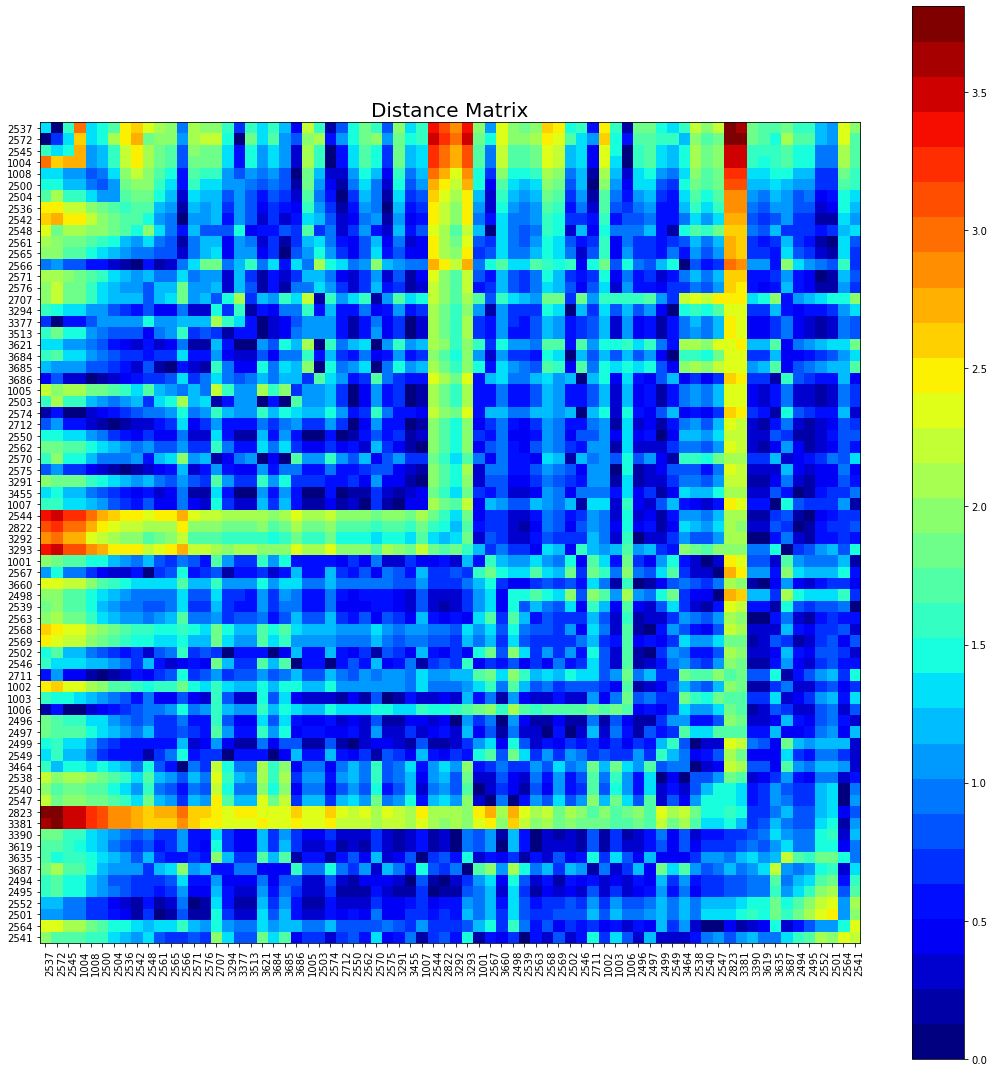

In [8]:
# Plot Distance matrix
fig, ax = plt.subplots(figsize=(15,15))
cmap = cmx.get_cmap('jet', 30)

im = ax.imshow(distances, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(df_stations)))
ax.set_yticks(np.arange(len(df_stations)))

ax.set_xticklabels(df_stations['station_id'])
ax.set_yticklabels(df_stations['station_id'])


plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")
        
ax.set_title("Distance Matrix", fontsize=20)
fig.tight_layout()
plt.show()

From a quick visual analysis we can see that most stations are approximaty 1.0-1.5 miles apart from each other. This is supported by looking at the mean of the distances matrix, or average distance between stations:

In [9]:
print(f'The average distance between stations: {np.mean(distances)}')

The average distance between stations: 1.0938172395341623


Although helpful, the above 2d histogram, does not provide an intuitive view of the spatial layout of the various stations. To gain such intuitions, we plot the stations over a map of downtown austin:

/Users/blacknerd/anaconda3/envs/datasci/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(0.5, 1.0, 'Austin BikeShare Stations')

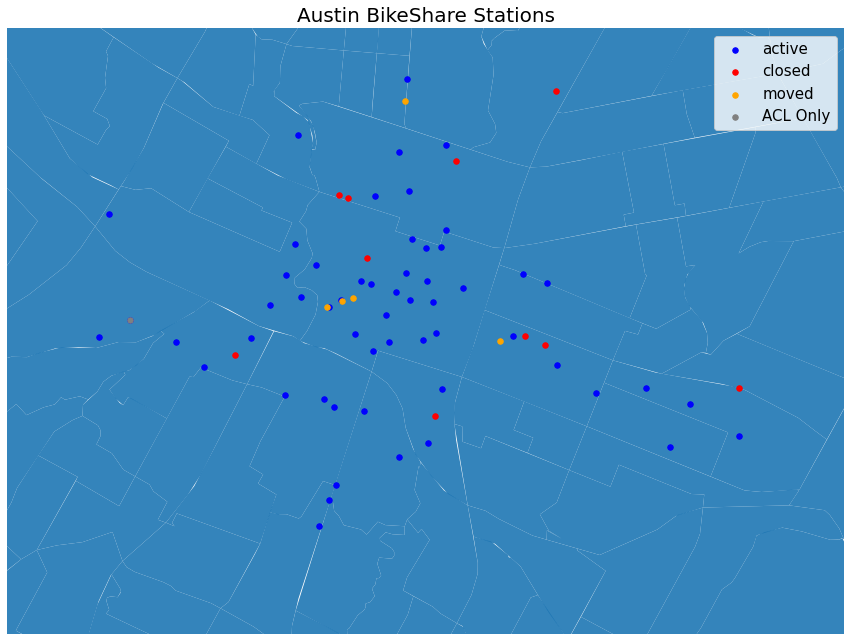

In [10]:
# Read in shape file of downtown austin
street_map = gpd.read_file('plots/geo_export_c3f89ccb-e6f4-42de-bc0b-26ee85e945bf.shp')
crs = {'init': 'epsg:4326'}

# Convert location data and create new dataframe
geometry = [Point(xy) for xy in zip(df_stations['longitude'], 
                                   df_stations['latitude'])]
df_locs = gpd.GeoDataFrame(df_stations,
                           crs=crs,
                           geometry=geometry)

# Plot with station status
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.9)
df_locs[df_locs['status']=="active"].plot(ax=ax, markersize=30,
                                   color="blue", marker="o",
                                   label="active")
df_locs[df_locs['status']=="closed"].plot(ax=ax, markersize=30,
                                   color="red", marker="o",
                                   label="closed")
df_locs[df_locs['status']=="moved"].plot(ax=ax, markersize=30, 
                                   color="orange", marker="o",
                                   label="moved")
df_locs[df_locs['status']=="ACL only"].plot(ax=ax, markersize=30,
                                   color="grey", marker="o",
                                   label="ACL Only")
plt.legend(prop={"size":15})
plt.ylim(30.24, 30.29)
plt.xlim(-97.78, -97.70)
plt.axis('off')
plt.title("Austin BikeShare Stations", fontsize=20)

#### Trips

Quick view of the 'austin_bikeshare_trips.csv' file.

In [11]:
df_trips.head()

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0


Although some data is missing, data cleaning is performed in the appropriate questions section

In [12]:
# Check to see if any values are missing
print(f'Length of the dataset is {len(df_trips)}')
print('Length of each column:')
df_trips.count()

Length of the dataset is 649231
Length of each column:


bikeid                648508
checkout_time         649231
duration_minutes      649231
end_station_id        629389
end_station_name      649231
month                 618479
start_station_id      630190
start_station_name    649231
start_time            649231
subscriber_type       647154
trip_id               649231
year                  618479
dtype: int64

#### Weather
Quick view of the 'austin_weather.csv' file.

In [13]:
df_weather.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


Although all the data appears to be present, not all columns are of non-numeric types. These columns contain '-' to represent days without readings. Handling of these issues is performed in the questions section.

In [14]:
# Check to see if any values are missing
print(f'Length of the dataset is {len(df_weather)}')
print('Length of each column:')
df_weather.count()

Length of the dataset is 1319
Length of each column:


Date                          1319
TempHighF                     1319
TempAvgF                      1319
TempLowF                      1319
DewPointHighF                 1319
DewPointAvgF                  1319
DewPointLowF                  1319
HumidityHighPercent           1319
HumidityAvgPercent            1319
HumidityLowPercent            1319
SeaLevelPressureHighInches    1319
SeaLevelPressureAvgInches     1319
SeaLevelPressureLowInches     1319
VisibilityHighMiles           1319
VisibilityAvgMiles            1319
VisibilityLowMiles            1319
WindHighMPH                   1319
WindAvgMPH                    1319
WindGustMPH                   1319
PrecipitationSumInches        1319
Events                        1319
dtype: int64

In [15]:
print("Column data types:")
df_weather.dtypes

Column data types:


Date                          object
TempHighF                      int64
TempAvgF                       int64
TempLowF                       int64
DewPointHighF                 object
DewPointAvgF                  object
DewPointLowF                  object
HumidityHighPercent           object
HumidityAvgPercent            object
HumidityLowPercent            object
SeaLevelPressureHighInches    object
SeaLevelPressureAvgInches     object
SeaLevelPressureLowInches     object
VisibilityHighMiles           object
VisibilityAvgMiles            object
VisibilityLowMiles            object
WindHighMPH                   object
WindAvgMPH                    object
WindGustMPH                   object
PrecipitationSumInches        object
Events                        object
dtype: object

## Questions:
* Which weather variable is most correlated with the frequency of trips?
   * How does this relationship vary across different subscriber types?
* Which subscriber type most frequently uses the bike service?
    * Has this pattern changed with time
* What is the traffic distribution across stations?
    * In traffic, and out traffic?
    * Do certain stations tend to accumulate bikes? Assuming no outside intervention, will some sites be low on or lacking bikes?

### Question 1: Weather Conditions and Trip Frequency and Duration

Which weather conditions are most closely correlated with trip frequency, and duration, what type of correlation do these parameters have? How do these relationship vary across different subscriber types?

#### Part 1: Which Weather Conditions are most correlated with trip frequency

In [16]:
# Replace placeholder variables with np.nan
df_weather = df_weather.replace('-', np.nan)
df_weather = df_weather.replace('T', np.nan)

# Convert columns of type 'object' to numeric types
obj_cols = []
for col, t in dict(df_weather.dtypes).items():
    if t == np.object and col not in ['Date', 'Events']:
        obj_cols.append(col)

df_weather[obj_cols] = df_weather[obj_cols].apply(pd.to_numeric, axis=1)

Since the data in question is weather, interpolating missing entries for continuous variables (average Temperature, average humidity, etc...) seems appropriate.

In [17]:
# Interpolate missing data
df_weather[obj_cols] = df_weather[obj_cols].interpolate()

In [18]:
# Create date range for period of observation
start_date = datetime.datetime.strptime(min(df_trips['start_time']), '%Y-%m-%d %H:%M:%S')
end_date = datetime.datetime.strptime(max(df_trips['start_time']), '%Y-%m-%d %H:%M:%S')

rng = pd.date_range(start=str(start_date.date()), end=str(end_date.date()))
rng = rng.strftime("%Y-%m-%d")

In [19]:
# Calculate number of trips on each day
day_count= np.zeros((len(rng)))

for i, date in enumerate(df_trips['start_time']):
    days = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    days = days.date() - start_date.date()
    day_count[days.days] += 1

In [20]:
# Create dummy variables for Events column
event_types = ["Rain", "Thunderstorm", "Fog", "Snow"]
events = np.zeros((len(df_weather), len(event_types)))

for i, env in enumerate(df_weather['Events']):
    env_list = env.split(',')
    env_list = [x.strip() for x in env_list]
    
    for l in env_list:
        ind = event_types.index(l) if l in event_types else None
   
        if ind is not None:
            events[i, ind]  = 1

df_events = pd.DataFrame(events, columns=event_types)

df_weather = pd.concat([df_weather, df_events], axis=1)
df_weather = df_weather.drop(['Events'], axis=1)

In [21]:
# Create new dataframe with day count and weather data
df_date = pd.DataFrame({'Date': rng, 'num_trips':day_count})
df_date = df_date.set_index('Date').join(df_weather.set_index('Date'))

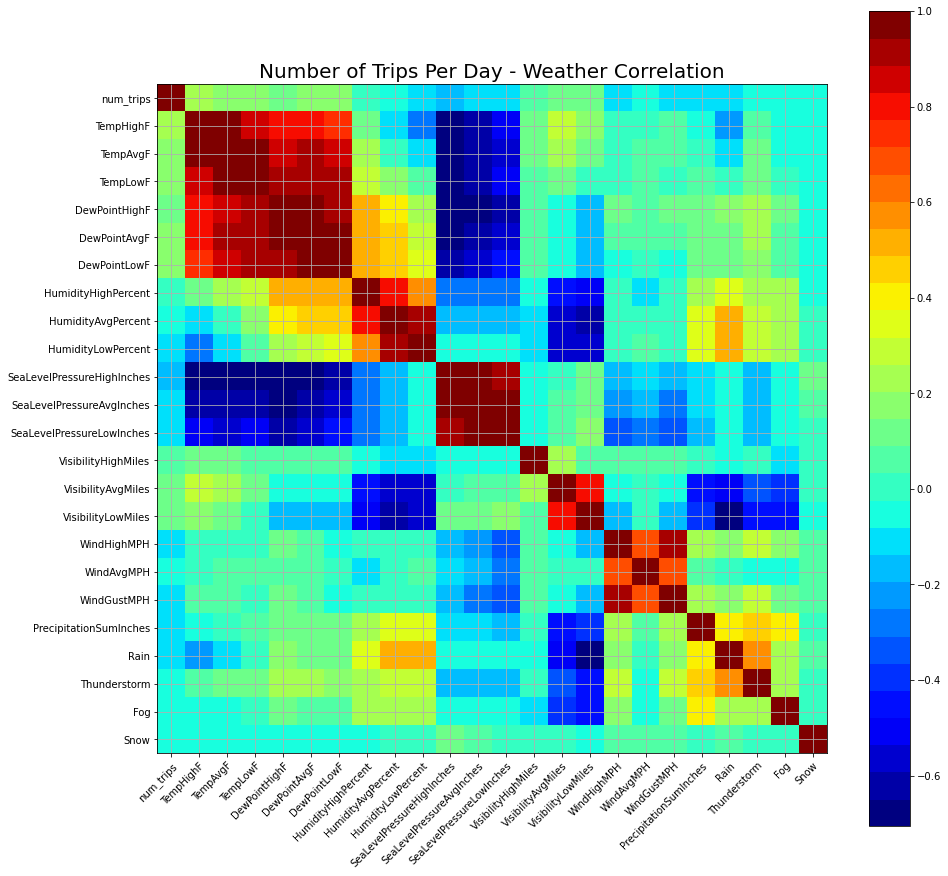

In [22]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(15,15))
cmap = cmx.get_cmap('jet', 30)
cax = ax.imshow(df_date.corr(), interpolation="nearest", cmap=cmap)
ax.grid(True)
plt.title('Number of Trips Per Day - Weather Correlation', fontsize=20)
labels = list(df_date.corr().columns)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels,fontsize=10)
ax.set_yticklabels(labels,fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

fig.colorbar(cax)
plt.show()

As we might expect, the related conditions: the average, high, and low for each variable are most highly correlated. Analyzing the 1st row of the matrix, we see that the number of trips per day is most strongly correlated with the temperature, with a positive correlation indicating that trips more frequently occur when temperatures are higher. We see that the next highest variable groups are dewpoint, which is highly correlated with temperature and visibility which is not.

#### Part 2: Study how the relationship between weather conditions vary with subscriber types
Study how correlation matrix varies by subscriber type, or which conditions are most likely to affect different subscriber types.

In [23]:
df_trips['subscriber_type'].value_counts()

Walk Up                                          282170
Local365                                         126517
24-Hour Kiosk (Austin B-cycle)                   108672
Local30                                           37061
Annual Membership (Austin B-cycle)                30306
Weekender                                         24614
Explorer                                           8246
Local365 ($80 plus tax)                            4005
Founding Member                                    3550
7-Day                                              3137
Founding Member (Austin B-cycle)                   2764
7-Day Membership (Austin B-cycle)                  2760
Local365+Guest Pass                                2567
Semester Membership (Austin B-cycle)               2426
Semester Membership                                 900
Local30 ($11 plus tax)                              840
Annual                                              799
24-Hour-Online (Austin B-cycle)                 

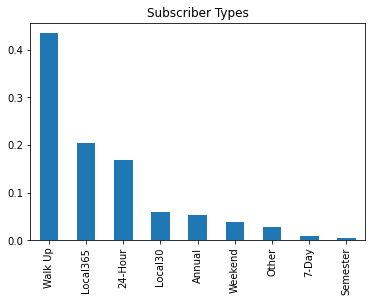

In [24]:
# Reduce the number of subscriber types
pos_types = ['Walk Up', 'Weekend', 'Other', 'Semester', 'Annual', '24-Hour', '7-Day', 'Local365', 'Local30']

sub_map = {}
for val in list(df_trips['subscriber_type'].value_counts().keys()):
    for t in pos_types:
        if t in val:
            sub_map[val] = t
            break
        else:
            sub_map[val] = 'Other'
sub_map[np.nan] = 'Other'

convert = lambda row: sub_map[row['subscriber_type']]
df_trips['subscriber_type'] = df_trips.apply(convert, axis=1)

# Plot subscriber type histograms
sub_type_count = df_trips['subscriber_type'].value_counts()

(sub_type_count/df_trips.shape[0]).plot(kind="bar");
plt.title("Subscriber Types");

We see that most users who use the service are walk-ups

In [25]:
def get_day_count_by_sub(df, start_date, rng, pos_types, rtype='days'):
    """
    Gets the number of rides per day by subscriber type
    
    Args:
        df (panda dataframe): dataframe to search in
        start_date (datetime date): first date in the study
        rng (panda date range): range of dates in the study
        pos_types (list): list of subscriber types
        rtype (string): frequency at which to bin data ('days', 'months'), optional,
            defaults to days
    
    Returns:
        (numpy array): Array trips per day or months of size len(range)xlen(pos_type)
    """
    day_count= np.zeros((len(rng) ,len(pos_types)))
    
    for _ , val in df[['start_time', 'subscriber_type', 'duration_minutes']].iterrows():
        sub_type_index = pos_types.index(val['subscriber_type'])
        days = datetime.datetime.strptime(val['start_time'], '%Y-%m-%d %H:%M:%S')
        if rtype == 'days':
            days = days.date() - start_date.date()
            day_count[days.days, sub_type_index] += 1
        elif rtype == 'months':
            days = days.year*12 + days.month - (start_date.year*12 + start_date.month)
            day_count[days, sub_type_index] += 1
        else:
            raise ValueError('Invalid rtype')
        
    return day_count

def get_dataframe_by_sub(day_count, rng, df_weather):
    """
    Create dataframe for type of subscriber
    
    Args:
        day_count (numpy array): numpy array of trips per day by subscriber.
            Array of size (number of days in study) by (number of subscriber types)
        rng (panda date range): range of dates in the study
        df_weather (panda dataframe): dataframe of weather conditions to join with each
            subscriber type dataframe

    Returns:
        (list of pandas dataframe): list of dataframe for each subscriber type
    """
    corr_arrs = []
    
    for i in range(day_count.shape[1]):
        df_date = pd.DataFrame({'Date': rng, 'num_trips':day_count[:,i]})
        df_date = df_date.set_index('Date').join(df_weather.set_index('Date'))
        
        corr_arrs.append(df_date)
        
    return corr_arrs


In [26]:
sub_day_count = get_day_count_by_sub(df_trips, start_date, rng, pos_types)
corr_arrs = get_dataframe_by_sub(sub_day_count, rng, df_weather)

In [27]:
# Create correlation matrix for each subscriber type df
# Grab the first row pertaining to number of trips

num_trips_corr = np.zeros((len(corr_arrs), corr_arrs[0].corr().shape[1]))

for i, arr in enumerate(corr_arrs):
    num_trips_corr[i,:] = arr.corr().iloc[0]

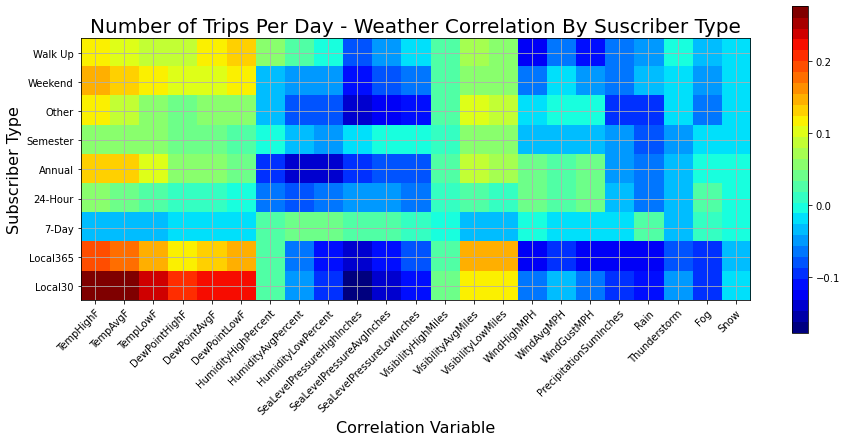

In [28]:
# Plot the matrix of number of trips

fig, ax = plt.subplots(figsize=(15,6))
cmap = cmx.get_cmap('jet', 30)
cax = ax.imshow(num_trips_corr[:,1:], interpolation="nearest", cmap=cmap)
ax.grid(True)
plt.title('Number of Trips Per Day - Weather Correlation By Suscriber Type', fontsize=20)
labels = [x for x in corr_arrs[0].corr().columns if x != "num_trips"]

ax.set_yticks(range(len(pos_types)))
ax.set_xticks(range(len(labels)))

ax.set_yticklabels(pos_types,fontsize=10)
ax.set_xticklabels(labels,fontsize=10)

plt.xlabel("Correlation Variable", fontsize=16)
plt.ylabel("Subscriber Type", fontsize=16)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

fig.colorbar(cax)
plt.show()

### Question 2: Suscriber Type Utilization

Which type of subscriber, most frequently uses the service? Has this trend changed over time? 

#### Part 1: Total utilization

In the previous question, we saw that walk up subscribers were most likely to use the service. Now an analysis of the duration of each trip by subscriber is provided

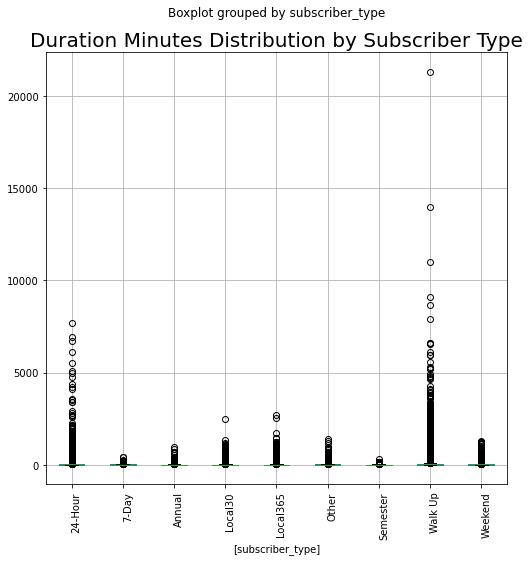

In [29]:
# Create Box Plot of trip durations
df_freq = df_trips[['duration_minutes', 'subscriber_type']]

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot(1,1,1)
df_freq.boxplot(by='subscriber_type', ax=ax)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")

plt.title('Duration Minutes Distribution by Subscriber Type', fontsize=20)
plt.show()

Due to outliers, the above plot is difficult to interpret, so we remove them in the plot below

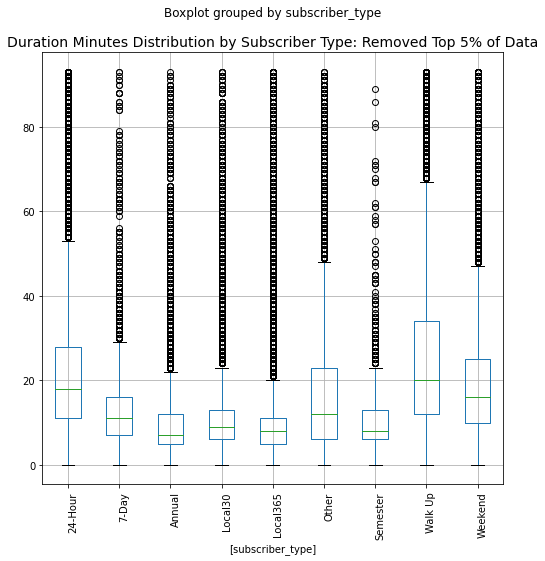

In [30]:
# Create Box Plot of trip durations removing outliers
df_freq = df_freq[df_freq['duration_minutes']
                .between(df_freq['duration_minutes'].quantile(.00), df_freq['duration_minutes'].quantile(.95))]

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot(1,1,1)
df_freq.boxplot(by='subscriber_type', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")
plt.title("Duration Minutes Distribution by Subscriber Type: Removed Top 5% of Data", fontsize=14)
plt.show()

Now we see that in addition to making the most frequent amount of trips, walk up users also tend to take longer trips on average then others subscriber types.

#### Part 2: Historical utilization

In [31]:
# Get range of study period by months
m_rng = pd.date_range(start=str(start_date.date()), end=str(end_date.date()), freq='M')
m_rng = m_rng.strftime("%Y-%m-%d")

In [32]:
# get array of avg trip durations by subscriber types by month
sub_month_count = get_day_count_by_sub(df_trips, start_date, m_rng, pos_types, rtype='months')

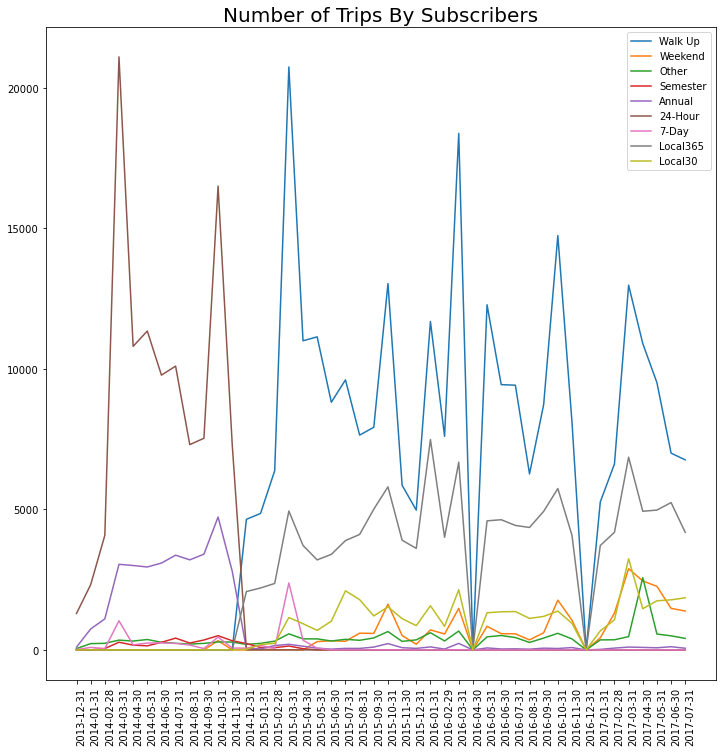

In [33]:
# Create plot of number of trips 
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1)

for i, row in enumerate(np.transpose(sub_month_count)):
    ax.plot(range(len(m_rng)), row, label=pos_types[i])

plt.xticks(np.arange(len(m_rng)), labels=m_rng)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")
plt.title("Number of Trips By Subscribers", fontsize=20)
plt.legend()
plt.show()

insert text here

In [34]:
def get_trip_dur_by_sub(df, start_date, rng, pos_types):
    """
    Gets the average trip duration per month by subscriber type
    
    Args:
        df (panda dataframe): dataframe to search in
        start_date (datetime date): first date in the study
        rng (panda date range): range of dates in the study
        pos_types (list): list of subscriber types
        rtype (string): frequency at which to bin data ('days', 'months'), optional,
            defaults to days
    
    Returns:
        (numpy array): Array trips per day or months of size len(range)xlen(pos_type)
    """
    duration_count= np.zeros((len(rng) ,len(pos_types)))
    duration_total= np.zeros((len(rng) ,len(pos_types)))
    
    for _ , val in df[['start_time', 'subscriber_type', 'duration_minutes']].iterrows():
        sub_type_index = pos_types.index(val['subscriber_type'])
        days = datetime.datetime.strptime(val['start_time'], '%Y-%m-%d %H:%M:%S')
        days = days.year*12 + days.month - (start_date.year*12 + start_date.month)
        
        duration_total[days, sub_type_index] += val['duration_minutes']
        duration_count[days, sub_type_index] += 1
     
    # possible to divide by 0 for months in which no subscribers of a type 
    # took a trip. If so should be 0/0
    duration = np.divide(duration_total, duration_count)
    return np.nan_to_num(duration)

In [35]:
# get array of avg trip durations by subscriber types by month
sub_month_duration = get_trip_dur_by_sub(df_trips, start_date, m_rng, pos_types)

<ipython-input-34-2e38c9e66f1d>:29: RuntimeWarning: invalid value encountered in true_divide
  duration = np.divide(duration_total, duration_count)


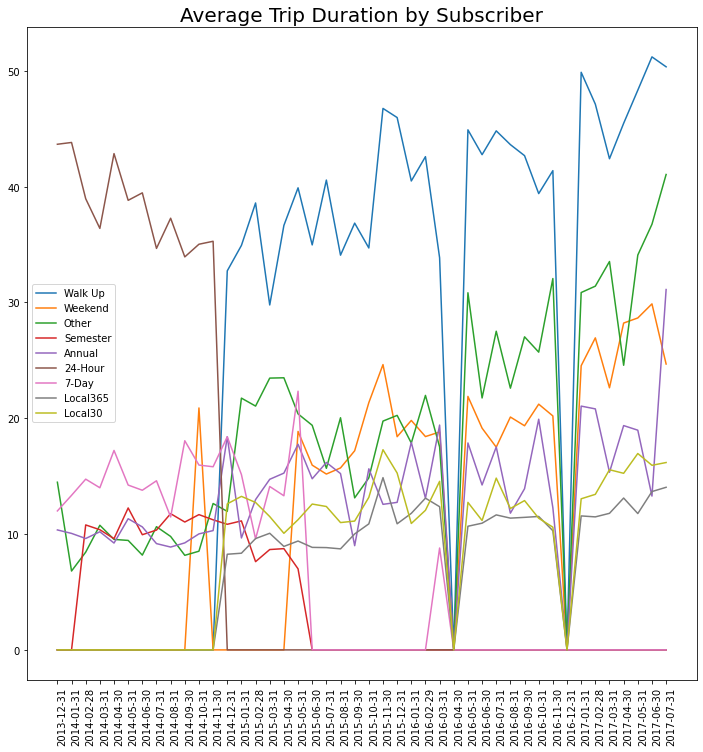

In [36]:
# Create plot of average trip duration
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1)

for i, row in enumerate(np.transpose(sub_month_duration)):
    ax.plot(range(len(m_rng)), row, label=pos_types[i])

plt.xticks(np.arange(len(m_rng)), labels=m_rng)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")
plt.title("Average Trip Duration by Subscriber", fontsize=20)
plt.legend()
plt.show()

insert text here

### Question 3: Station Traffic Distribution

What patterns do the in and out traffic at each station follow? Assuming that there is no outside intervention (company manually replacing or moving bikes) are there sites that are more likely to be low or lacking bikes?

#### Data Cleaning

In [37]:
df_flow = df_trips[['start_station_id', "end_station_id", 'start_station_name',
                 'end_station_name', 'start_time']]

In [38]:
# Some end stations names were found to be variations of those
# included in dataset.
station_id_maps = {
     'Zilker Park at Barton Springs & William Barton Drive':2574,
     'ACC - West & 12th': 2546,
     'Convention Center/ 3rd & Trinity': 2539,
     'Mobile Station': 999, # indicates event
     'East 11th Street at Victory Grill': 2568,
     'Red River @ LBJ Library': 1004,
     'Main Office': 1001,
     'Customer Service': 1001,
     'Repair Shop': 1001,
     'Mobile Station @ Bike Fest': 999,
     'MapJam at Pan Am Park': 999,
     'Shop': 1001,
     'MapJam at French Legation': 999,
     'MapJam at Hops & Grain Brewery': 999,
     'Missing': 0,
     'MapJam at Scoot Inn': 999,
     'Stolen': 0,
     'Mobile Station @ Unplugged': 999,
     'Marketing Event': 999,
     'Mobile Station @ Boardwalk Opening Ceremony': 999,
     'Re-branding': 1001,
     'Main Shop': 1001
}

fill_missing_end = lambda row: station_id_maps[row['end_station_name']] if np.isnan(row['end_station_id']) else row['end_station_id']
df_flow['end_id'] = df_flow.apply(fill_missing_end, axis=1)

<ipython-input-38-d6ef1704820a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow['end_id'] = df_flow.apply(fill_missing_end, axis=1)


In [39]:
fill_missing_st = lambda row: station_id_maps[row['start_station_name']] if np.isnan(row['start_station_id']) else row['start_station_id']
df_flow['start_id'] = df_flow.apply(fill_missing_st, axis=1)

<ipython-input-39-9f69df96a9b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow['start_id'] = df_flow.apply(fill_missing_st, axis=1)


In [40]:
df_stations.columns

Index(['latitude', 'location', 'longitude', 'name', 'station_id', 'status',
       'geometry'],
      dtype='object')

In [41]:
# Remove prev. id columns
df_flow = df_flow.drop(['start_station_id', 'end_station_id'], axis=1)

# Add additional rows to stations dataframe
# Located at the end of the available region
df_temp = pd.DataFrame([
    [30.2809, (30.28999, -97.7801), -97.7801, 'Event', 999, "Event", None],
    [30.2808, (30.28997, -97.7801), -97.7801, 'Missing/Stolen', 0, 'Missing/Stolen', None]],
    columns=df_stations.columns
)

df_stations = df_stations.append(df_temp, ignore_index=True)

#### Part 1: Over The Entire Survey Period

In [42]:
flow = [tuple(x) for x in df_flow.to_numpy()]
flow = Counter(list(flow))
flow = [(int(x[4]), int(x[3]), y) for x,y in flow.items()]

In [43]:
# Create Graph
G = nx.DiGraph()
G.add_nodes_from(list(df_stations['station_id']))
G.add_weighted_edges_from(flow)

In [44]:
# Get the net degree (in degree - out degree)
# as a measure of flow through each station
net_degree = []
for elem in G.nodes:
    net_degree.append((elem, {
                           "size": G.in_degree(elem, weight="weight") - G.out_degree(elem, weight="weight")
    }))    

# Min-max scale the degree
scaled_net_degree = []
max_size = max([x[1]["size"] for x in net_degree])
min_size = min([x[1]["size"] for x in net_degree])

for elem, vals in net_degree:
    scaled_net_degree.append((elem, {
       "size": (vals["size"]-min_size) / (max_size-min_size) 
    }))

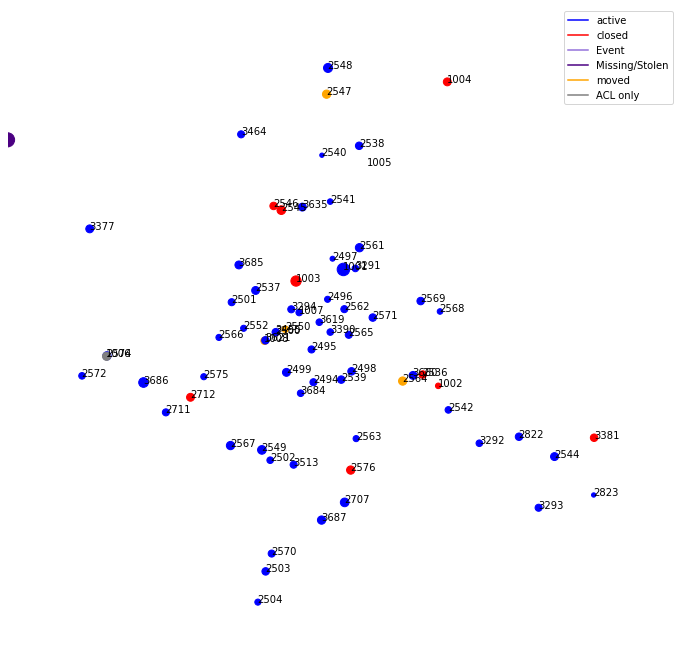

In [45]:
# Optionally label nodes
annote = True # makes graph messy

# Created graph of scaled nodes
G_scaled = nx.Graph()
G_scaled.add_nodes_from(scaled_net_degree)

d = dict(G_scaled.nodes(data=True)).values()

# Plot graph
color_map = {
    "active": "blue",
    "closed": "red",
    "Event": "mediumpurple",
    "Missing/Stolen": "indigo",
    "moved": "orange",
    "ACL only": "grey"
}

y_off = -20e-6
x_off = -40e-6
pos = {}
colors = []

f, ax = plt.subplots(figsize=(12,12))

for i, row in df_stations.iterrows():
    pos[row['station_id']] = (row['longitude'], row['latitude'])
    colors.append(color_map[row['status']])
    
    if annote:
        ax.annotate(row['station_id'], (pos[row['station_id']][0]+x_off, pos[row['station_id']][1]+y_off))

for label, color in color_map.items():
    ax.plot([0], [0], color=color, label=label)
    
nx.draw_networkx(G_scaled, pos, ax=ax, with_labels=False,
                 node_size=[v["size"]*200 for v in d], node_color=colors)
plt.legend()
ax.set_ylim([30.245, 30.290])
ax.set_xlim([-97.78, -97.70])

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.axis('off')
plt.show()

#### Part 2: By Month Analysis

In [46]:
m_rng = pd.date_range(start=str(start_date.date()), end=str(end_date.date()), freq='M')
m_rng = m_rng.strftime("%Y-%m-%d")

In [47]:
df_flow.head()

,start_station_name,end_station_name,start_time,end_id,start_id
0,Waller & 6th St.,Trinity & 6th Street,2015-03-19 19:12:00,2565.0,2536.0
1,2nd & Congress,South Congress & Academy,2016-10-30 02:06:04,2570.0,2494.0
2,Bullock Museum @ Congress & MLK,Convention Center / 4th St. @ MetroRail,2016-03-11 16:28:27,2498.0,2538.0
3,Capitol Station / Congress & 11th,Toomey Rd @ South Lamar,2014-11-23 15:12:00,2712.0,2497.0
4,Rainey St @ Cummings,MoPac Pedestrian Bridge @ Veterans Drive,2017-04-16 15:39:13,3377.0,2707.0


In [48]:
mat = np.zeros((
    len(m_rng), # number of months in study
    len(df_stations['station_id'])))

station_map = dict((key, i) for i, key in enumerate(list(df_stations['station_id'].value_counts().keys())))

for _, val in df_flow.iterrows():
    start_st = station_map[val['start_id']]
    end_st = station_map[val['end_id']]
        
    month = datetime.datetime.strptime(val['start_time'], '%Y-%m-%d %H:%M:%S')
    month = month.year*12 + month.month - (start_date.year*12 + start_date.month)
    
    mat[month, start_st] -= 1
    mat[month, end_st] += 1

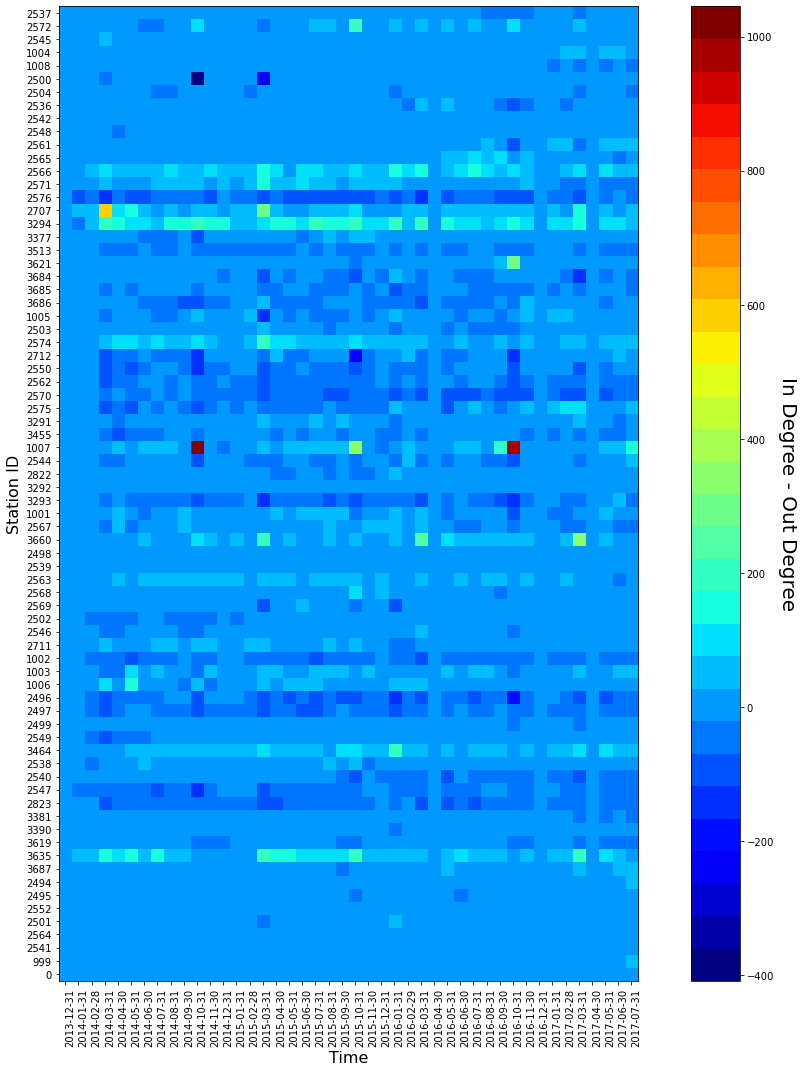

In [49]:
fig, ax = plt.subplots(figsize=(15,15))
cmap = cmx.get_cmap('jet', 30)

im = ax.imshow(np.transpose(mat), cmap=cmap)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("In Degree - Out Degree", fontsize=20, rotation=-90, va="bottom")

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Station ID", fontsize=16)

ax.set_yticks(np.arange(len(df_stations['station_id'])))
ax.set_xticks(np.arange(len(m_rng)))

ax.set_yticklabels(df_stations['station_id'])
ax.set_xticklabels(list(m_rng))

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")

fig.tight_layout()
plt.show()

In [50]:
# Add graph animation
class AnimateGraph:
    def __init__(self, nodes, mat, pos, colors):
        # Create Graph
        self.G = nx.Graph()
        self.G.add_nodes_from(nodes)
        self.mat = mat
        self.pos = pos
        self.colors = colors
    
    def _update_graph(self, num, thr, ax):
        ax.clear()
        size = self.mat[num,:]
        nx.draw_networkx(self.G, pos=self.pos, with_labels=False, 
                         node_color=self.colors, node_size=size)

    def animate_graph(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        plt.axis('off')
        thr=1
        
        # Create animation
        ani = animation.FuncAnimation(fig,self._update_graph,
                                     frames=mat.shape[0], fargs=(thr, ax))
        ani.save('anim.gif', writer='imagemagick')
        plt.close(ani._fig)

In [51]:
animate = False
display_animation = False

if animate:
    nodes = list(df_stations['station_id'])
    animate = AnimateGraph(nodes, mat, pos, colors)
    animate.animate_graph()
    
if display_animation:
    with open('anim.gif', 'rb') as file:
        display(Image(file.read()))

In [52]:
# Get Original Stations
bike_ids = dict.fromkeys(df_trips['bikeid'].value_counts().keys(),None)
station_ids = dict.fromkeys(df_stations['station_id'], 0)

In [53]:
# Determine the count of bikes originally at each station
for i, row in df_trips.sort_values('start_time').dropna().iterrows():
    if bike_ids[row['bikeid']]is None:
        bike_ids[row['bikeid']] = row['start_station_id']
        station_ids[row['start_station_id']] += 1

In [54]:
# Get Count of bikes at all stations
count_hist = np.zeros((mat.shape[0]+1, mat.shape[1]))
count_hist[0,:] = list(station_ids.values())

for i in range(mat.shape[0]):
    count_hist[i+1,:] = mat[i,:]+count_hist[i,:]
    
# print(i)

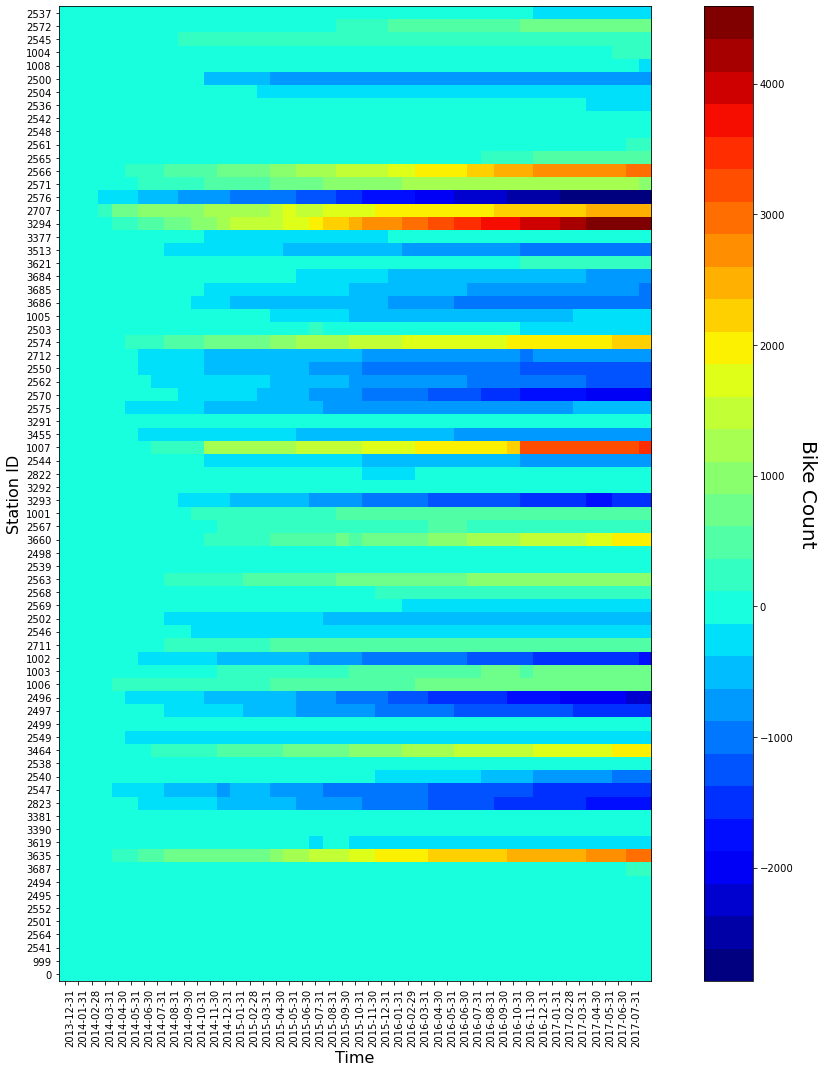

In [55]:
fig, ax = plt.subplots(figsize=(15,15))
cmap = cmx.get_cmap('jet', 30)

im = ax.imshow(np.transpose(count_hist), cmap=cmap)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bike Count", fontsize=20, rotation=-90, va="bottom")

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Station ID", fontsize=16)

ax.set_yticks(np.arange(len(df_stations['station_id'])))
ax.set_xticks(np.arange(len(m_rng)))

ax.set_yticklabels(df_stations['station_id'])
ax.set_xticklabels(list(m_rng))

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
        rotation_mode="anchor")

fig.tight_layout()
plt.show()